#IMPORTING LIBRARIES

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#DATASET, TRANSFORMATIONS AND VISUALISATIONS

In [3]:
transform_train=transforms.Compose([
                                    transforms.RandomResizedCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
transform_test=transforms.Compose([
                                    transforms.RandomResizedCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [4]:
trainset= torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)
testset= torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
num_classes=10

In [6]:
batch_size=4

In [7]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [8]:
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=True)

In [9]:
dataiter=iter(trainloader)
images,labels=dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())


torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
4


In [10]:
def imshow(img,title):
    npimg=img.numpy()/2+0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [11]:
def show_batch_images(dataloader):
    images, labels=next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img,title=[str(x.item()) for x in labels])

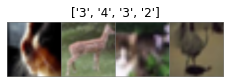

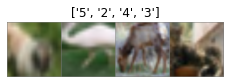

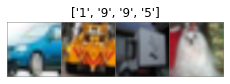

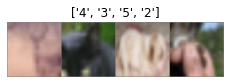

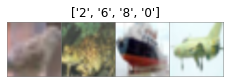

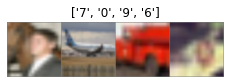

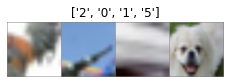

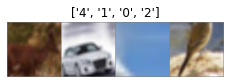

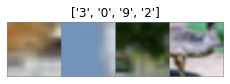

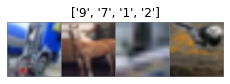

In [12]:
for i in range(10):
    show_batch_images(trainloader)

#CREATING VGG-16

In [13]:
from torchvision import models

In [14]:
vgg= models.vgg16_bn()

In [15]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [16]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [17]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [18]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [19]:
vgg.classifier=nn.Sequential(*mod_classifier)

In [20]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

#TRAINING CIFAR-10 DATASET

In [21]:
def evaluation(dataloader):
    total, correct= 0,0
    for data in dataloader:
        inputs, labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=vgg(inputs)
        _, pred=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(pred==labels).sum().item()
    return 100*correct/total

In [22]:
batch_size=16
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

In [23]:
vgg=vgg.to(device)
loss_fn=nn.CrossEntropyLoss()
opt=optim.SGD(vgg.parameters(),lr=0.001)

In [ ]:
%%time
loss_arr=[]
loss_epoch_arr=[]
max_epochs=5

n_iters= np.ceil(50000/batch_size)

for epoch in range(max_epochs):
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)

        opt.zero_grad()

        outputs=vgg(inputs)
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt.step()

        del inputs,labels,outputs
        torch.cuda.empty_cache()

        if i%100==0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i,n_iters,loss.item()))

    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch,max_epochs,evaluation(testloader),evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

#FREEZE LAYERS OF CONVOLUTION OPERATIONS

In [25]:
batch_size=16
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

In [26]:
vgg=models.vgg16_bn(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [27]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [28]:
vgg.classifier=nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [44]:
for param in vgg.parameters():
    param.requires_grad=False

In [45]:
def evaluation(dataloader):
    total, correct= 0,0
    for data in dataloader:
        inputs, labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=vgg(inputs)
        _, pred=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(pred==labels).sum().item()
    return 100*correct/total

In [46]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6]=nn.Linear(final_in_features, num_classes)

In [47]:
vgg=vgg.to(device)
loss_fn=nn.CrossEntropyLoss()
opt=optim.SGD(vgg.parameters(),lr=0.005)

In [48]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


Iteration: 0/3125, Loss: 2.32
Iteration: 100/3125, Loss: 1.79
Iteration: 200/3125, Loss: 1.17
Iteration: 300/3125, Loss: 1.55
Iteration: 400/3125, Loss: 1.58
Iteration: 500/3125, Loss: 1.36
Iteration: 600/3125, Loss: 1.77
Iteration: 700/3125, Loss: 1.09
Iteration: 800/3125, Loss: 1.52
Iteration: 900/3125, Loss: 1.50
Iteration: 1000/3125, Loss: 1.55
Iteration: 1100/3125, Loss: 1.71
Iteration: 1200/3125, Loss: 1.12
Iteration: 1300/3125, Loss: 1.26
Iteration: 1400/3125, Loss: 1.40
Iteration: 1500/3125, Loss: 1.56
Iteration: 1600/3125, Loss: 1.16
Iteration: 1700/3125, Loss: 1.68
Iteration: 1800/3125, Loss: 1.25
Iteration: 1900/3125, Loss: 1.19
Iteration: 2000/3125, Loss: 1.94
Iteration: 2100/3125, Loss: 1.87
Iteration: 2200/3125, Loss: 1.33
Iteration: 2300/3125, Loss: 0.93
Iteration: 2400/3125, Loss: 1.01
Iteration: 2500/3125, Loss: 1.35
Iteration: 2600/3125, Loss: 0.84
Iteration: 2700/3125, Loss: 1.52
Iteration: 2800/3125, Loss: 1.49
Iteration: 2900/3125, Loss: 1.33
Iteration: 3000/3125, 

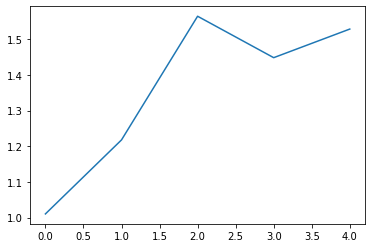

CPU times: user 1h 3min 5s, sys: 3min 20s, total: 1h 6min 26s
Wall time: 1h 7min 9s


In [49]:
%%time
loss_arr=[]
loss_epoch_arr=[]
max_epochs=5

n_iters= np.ceil(50000/batch_size)

for epoch in range(max_epochs):
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)

        opt.zero_grad()

        outputs=vgg(inputs)
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt.step()

        del inputs,labels,outputs
        torch.cuda.empty_cache()

        if i%100==0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i,n_iters,loss.item()))

    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch,max_epochs,evaluation(testloader),evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

# With Model Copies 

In [52]:
import copy

In [55]:
def evaluation(net,dataloader):
    total, correct= 0,0
    for data in dataloader:
        inputs, labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=net(inputs)
        _, pred=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(pred==labels).sum().item()
    return 100*correct/total

min loss 1.1965019702911377
Iteration: 0/3125, Loss: 1.20
min loss 1.0680593252182007
min loss 0.783547043800354
min loss 0.773631751537323
min loss 0.6986558437347412
min loss 0.6779538989067078
min loss 0.6455942988395691
Iteration: 100/3125, Loss: 0.84
min loss 0.4923464059829712
Iteration: 200/3125, Loss: 1.34
Iteration: 300/3125, Loss: 1.09
Iteration: 400/3125, Loss: 1.41
Iteration: 500/3125, Loss: 1.09
Iteration: 600/3125, Loss: 1.07
Iteration: 700/3125, Loss: 1.35
Iteration: 800/3125, Loss: 1.28
Iteration: 900/3125, Loss: 0.91
Iteration: 1000/3125, Loss: 1.35
Iteration: 1100/3125, Loss: 2.68
Iteration: 1200/3125, Loss: 1.35
Iteration: 1300/3125, Loss: 1.31
Iteration: 1400/3125, Loss: 1.14
Iteration: 1500/3125, Loss: 1.73
Iteration: 1600/3125, Loss: 1.35
Iteration: 1700/3125, Loss: 1.23
Iteration: 1800/3125, Loss: 1.67
Iteration: 1900/3125, Loss: 1.84
Iteration: 2000/3125, Loss: 1.58
Iteration: 2100/3125, Loss: 1.45
Iteration: 2200/3125, Loss: 1.09
Iteration: 2300/3125, Loss: 1.5

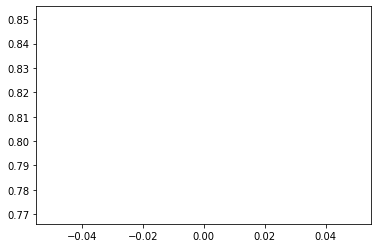

CPU times: user 12min 29s, sys: 31.2 s, total: 13min
Wall time: 13min 9s


In [57]:
%%time
loss_epoch_arr=[]
max_epochs=1
n_iters= np.ceil(50000/batch_size)

min_loss=1000

for epoch in range(max_epochs):
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)

        opt.zero_grad()

        outputs=vgg(inputs)
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt.step()

        if min_loss>loss.item():
            min_loss=loss.item()
            best_model= copy.deepcopy(vgg.state_dict())
            print('min loss',min_loss)

        del inputs,labels,outputs
        torch.cuda.empty_cache()

        if i%100==0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i,n_iters,loss.item()))

    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch,max_epochs,evaluation(vgg,testloader),evaluation(vgg,trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

In [58]:
vgg.load_state_dict(best_model)
print(evaluation(vgg,testloader),evaluation(vgg,trainloader))

54.07 54.356


#ResNet Model

In [59]:
resnet=models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
for param in vgg.parameters():
    param.requires_grad=False

In [62]:
final_in_features = resnet.fc.in_features
resnet.fc=nn.Linear(final_in_features, num_classes)

In [63]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

In [64]:
vgg=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt=optim.SGD(resnet.parameters(),lr=0.005)

min loss 2.518519639968872
Iteration: 0/3125, Loss: 2.52
min loss 2.3036999702453613
min loss 2.237006902694702
min loss 2.126354455947876
min loss 2.1069939136505127
min loss 2.072442054748535
min loss 1.7937636375427246
min loss 1.7694122791290283
min loss 1.7334147691726685
min loss 1.6693110466003418
min loss 1.618713617324829
min loss 1.5606627464294434
min loss 1.5438487529754639
Iteration: 100/3125, Loss: 1.66
min loss 1.5157581567764282
min loss 1.439650535583496
min loss 1.3305176496505737
min loss 1.2894046306610107
min loss 1.1636865139007568
min loss 1.133501410484314
min loss 0.9619630575180054
Iteration: 200/3125, Loss: 1.44
min loss 0.8444282412528992
Iteration: 300/3125, Loss: 1.81
min loss 0.8404400944709778
min loss 0.8369896411895752
min loss 0.7652977705001831
Iteration: 400/3125, Loss: 0.94
min loss 0.7646467685699463
min loss 0.7025132775306702
min loss 0.6343236565589905
Iteration: 500/3125, Loss: 1.00
min loss 0.5741713643074036
Iteration: 600/3125, Loss: 1.14
m

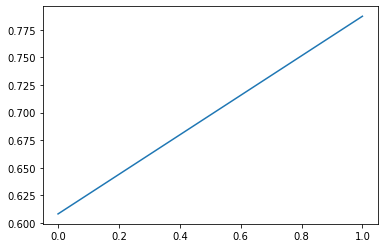

CPU times: user 12min 36s, sys: 10.4 s, total: 12min 47s
Wall time: 12min 54s


In [65]:
%%time
loss_epoch_arr=[]
max_epochs=1
n_iters= np.ceil(50000/batch_size)

min_loss=1000

for epoch in range(max_epochs):
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)

        opt.zero_grad()

        outputs=resnet(inputs)
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt.step()

        if min_loss>loss.item():
            min_loss=loss.item()
            best_model= copy.deepcopy(resnet.state_dict())
            print('min loss',min_loss)

        del inputs,labels,outputs
        torch.cuda.empty_cache()

        if i%100==0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i,n_iters,loss.item()))

    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch,max_epochs,evaluation(inception,testloader),evaluation(inception,trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

In [66]:
resnet.load_state_dict(best_model)
print(evaluation(resnet,testloader),evaluation(resnet,trainloader))

76.77 78.34


#Inception Model

In [67]:
inception=models.inception_v3(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [68]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [69]:
for params in inception.parameters():
    params.requires_grad=False

In [74]:
aux_in_features=inception.AuxLogits.fc.in_features
inception.AuxLogits.fc=nn.Linear(aux_in_features, num_classes)

In [75]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [76]:
transform_train=transforms.Compose([
                                    transforms.RandomResizedCrop(299),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
transform_test=transforms.Compose([
                                    transforms.RandomResizedCrop(299),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [80]:
trainset= torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)
testset= torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [81]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False)

In [83]:
inception=inception.to(device)
loss_fn=nn.CrossEntropyLoss()
opt=optim.SGD(inception.parameters(),lr=0.001)

In [86]:
def evaluation(net,dataloader):
    total, correct= 0,0
    for data in dataloader:
        inputs, labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        outputs,aux_outputs=net(inputs)
        _, pred=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(pred==labels).sum().item()
    return 100*correct/total

min loss 8.118363380432129
Iteration: 0/3125, Loss: 8.12
min loss 8.079325675964355
min loss 7.999716758728027
min loss 7.9208149909973145
min loss 7.707714080810547
min loss 7.653378009796143
min loss 7.5191874504089355
Iteration: 100/3125, Loss: 8.13
min loss 7.281717300415039
Iteration: 200/3125, Loss: 7.83
Iteration: 300/3125, Loss: 8.37
Iteration: 400/3125, Loss: 8.08
Iteration: 500/3125, Loss: 8.39
Iteration: 600/3125, Loss: 7.73
Iteration: 700/3125, Loss: 8.08
Iteration: 800/3125, Loss: 8.12
Iteration: 900/3125, Loss: 8.25
Iteration: 1000/3125, Loss: 8.20
Iteration: 1100/3125, Loss: 8.35
Iteration: 1200/3125, Loss: 8.33
Iteration: 1300/3125, Loss: 7.68
Iteration: 1400/3125, Loss: 8.27
Iteration: 1500/3125, Loss: 8.09
Iteration: 1600/3125, Loss: 8.31
Iteration: 1700/3125, Loss: 8.21
Iteration: 1800/3125, Loss: 8.12
Iteration: 1900/3125, Loss: 8.32
min loss 7.277952671051025
Iteration: 2000/3125, Loss: 8.20
Iteration: 2100/3125, Loss: 8.25
Iteration: 2200/3125, Loss: 7.99
Iteratio

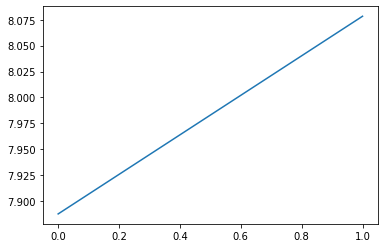

CPU times: user 21min 11s, sys: 15.3 s, total: 21min 26s
Wall time: 21min 29s


In [87]:
%%time
loss_epoch_arr=[]
max_epochs=2
n_iters= np.ceil(50000/batch_size)

min_loss=1000

for epoch in range(max_epochs):
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)

        opt.zero_grad()

        outputs,aux_outputs=inception(inputs)
        loss=loss_fn(outputs,labels)+0.3*loss_fn(aux_outputs,labels)
        loss.backward()
        opt.step()

        if min_loss>loss.item():
            min_loss=loss.item()
            best_model= copy.deepcopy(inception.state_dict())
            print('min loss',min_loss)

        del inputs,labels,outputs
        torch.cuda.empty_cache()

        if i%100==0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i,n_iters,loss.item()))

    loss_epoch_arr.append(loss.item())

print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch,max_epochs,evaluation(inception,testloader),evaluation(inception,trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

In [88]:
inception.load_state_dict(best_model)
print(evaluation(inception,testloader),evaluation(inception,trainloader))

0.128 0.132
